In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from torchmetrics import HammingDistance, Accuracy, F1Score, Precision, Recall, ExactMatch
import seaborn as sns
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

In [86]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Import Data

In [87]:
job_level_data = pd.read_csv("../data/JobLevelData_preproc.csv")
job_level_data

,Title,Label
0,Vice President Director of Systems Engineering,"[0, 0, 0, 0, 1]"
1,Systems Engineer Systems Architect,"[0, 0, 1, 1, 0]"
2,Executive Director Global Informational Techno...,"[1, 1, 0, 0, 0]"
3,Chief Technology Officer Executive Director of...,"[1, 1, 0, 0, 0]"
4,Vice President Chief Information Officer,"[0, 0, 0, 0, 1]"
...,...,...
2221,Net Software Architect and Team Project Lead,"[0, 0, 0, 1, 0]"
2222,Solutions Architect Technical Lead,"[0, 0, 1, 1, 0]"
2223,Manager Salesforcecom Administration and Relea...,"[0, 0, 0, 1, 0]"
2224,Innovation Automation Architect,"[0, 0, 0, 1, 0]"


In [88]:
classes_labels = ['Chief Officer', 'Director', 'Individual Contributor/Staff', 'Manager',
 'Vice President']

## Dataset Loading

In [89]:
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 64
MAX_EPOCHS = 50
EARLY_STOPPING_PAT = 4
THRESHOLD = 0.4

In [90]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-6_H-256_A-4')

In [91]:
# handle input data preprocessing
class JobTitlesDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = titles
        self.labels = labels.apply(eval)
        self.tokenizer = tokenizer
        self.max_len = max_len  # maximum length of tokenized sentence

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        encoded_data = self.tokenizer.encode_plus(
            self.titles[item],
            add_special_tokens=True,  # tokens required for BERT
            max_length=self.max_len,
            return_token_type_ids=False,  # no sentence pair task
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # differentiate between padding and data
            return_tensors='pt'
        )
        return {
            'input_ids': encoded_data['input_ids'].flatten(),
            'attention_mask': encoded_data['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

### Train Test Split

In [92]:
# TODO: implement stratification
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    job_level_data['Label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (1780,)
Test data: (446,)


In [93]:
train_dataset = JobTitlesDataset(
    titles=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = JobTitlesDataset(
    titles=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Model Definition and Training
BERT models are a powerful tools for various text classification problems. For this task, the mini BERT model was chosen due to its strong performance in understanding textual data and its lower complexity compared to the base BERT model. Although the model is computationally expensive, it is capable of capturing nuances in the data, such as misspellings, non-expanded abbreviations, variations in job titles.

However, it is acknowledged that BERT might not be the optimal solution due to its complexity and model size, which is approximately 50MB, especially given the nature of the data (short and simple sentences). An ideal approach would be to establish a baseline model with a simpler architecture and then compare it with the BERT model, for example, using TF-IDF vectorization combined with a Logistic Regression classifier.

Another strategy worth exploring is a hybrid approach, where BERT is used solely for generating embeddings that are then fed into a simpler classifier.

Due to time constraints, alternative models were not implemented, but are recommended for further exploration.

In [94]:
class JobTitleClassifier(nn.Module):
    def __init__(self, n_classes):
        super(JobTitleClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('google/bert_uncased_L-6_H-256_A-4')  # Pre-trained BERT-Mini model
        self.dropout = torch.nn.Dropout(0.4) # regularization
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes) # classification 
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        output = self.dropout(output.last_hidden_state[:, 0, :])
        output = self.linear(output)
        return output

model_bert_classifier = JobTitleClassifier(len(classes_labels)).to(device)

As highlighted in the EDA, the data is highly imbalanced. To address this, class weights will be calculated and passed to the loss function to give more weight to underrepresented classes.

In [95]:
# import labels_count from EDA notebook
labels_count = {'Chief Officer': 163,
 'Director': 497,
 'Individual Contributor/Staff': 1105,
 'Manager': 211,
 'Vice President': 403}

In [96]:
total_positives = sum(count for label, count in labels_count.items())
class_weights = [total_positives / count for label, count in labels_count.items()]

class_weights = np.array(class_weights)
class_weights = class_weights * (len(class_weights) / class_weights.sum())
class_weights = torch.FloatTensor(class_weights).to(device)

class_weights

tensor([1.8850, 0.6182, 0.2781, 1.4562, 0.7624], device='mps:0')

In [97]:
adam_optimizer = torch.optim.Adam(model_bert_classifier.parameters(), lr=1e-5)
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights) # includes sigmoid activation
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', patience=2, factor=0.2)

In [98]:
def train_classifier(model,
                     data_loader,
                     loss_fn,
                     optimizer,
                     device):
    model = model.train()
    losses = []

    for batch_num, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        true_labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, true_labels)
        losses.append(loss.item())
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(losses)


In [99]:
def validation(model,
               data_loader,
               loss_fn,
               device):
    model = model.eval()
    losses = []
    predictions = []
    targets = []

    # ensures no gradients are computed during test mode
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            true_labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            eval_loss = loss_fn(outputs, true_labels).item()
            losses.append(eval_loss)

            preds = torch.sigmoid(outputs)  # get probabilities
            predictions.append(preds.cpu())
            targets.append(true_labels.cpu())
            
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)

    return np.mean(losses), predictions, targets

### Training and Evaluation Process
According to [Correlation analysis of performance measures for multi-label classification (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0306457318300165), these are the most widely-used performance measures for multi-label classification:
- **Hamming Loss**: the most recommended due to its lack of correlation with other measures (avoiding redundancy) and being the most employed in literature at the time of paper writing. 
- **F1, Precision and Recall**: have strong correlation with each other and other metrics, making them representative measures that reduce the need to report multiple similar metrics. 
- **Subset Accuracy**: the most intuitive and strict metric, not considering partial matches.

In [100]:
classes_num = len(classes_labels)

hamming_loss = HammingDistance(task='multilabel', num_labels=classes_num).to(device)
accuracy = Accuracy(task='multilabel', num_labels=classes_num).to(device)
f1 = F1Score(task='multilabel', num_labels=classes_num).to(device)
precision = Precision(task='multilabel', num_labels=classes_num).to(device)
recall = Recall(task='multilabel', num_labels=classes_num).to(device)
subset_accuracy = ExactMatch(task="multilabel", num_labels=classes_num).to(device)

hamming_scores = []
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
subset_accuracy_scores = []

In [101]:
train_losses = []
val_losses = []

best_loss = float('inf')
best_model_weights = None
best_predictions = None
best_targets = None
patience = EARLY_STOPPING_PAT

for epoch in range(MAX_EPOCHS):
    print(f'Epoch {epoch + 1}')

    # Training
    train_loss = train_classifier(model_bert_classifier, train_loader, bce_loss, adam_optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss, predictions, targets = validation(model_bert_classifier, test_loader, bce_loss, device)
    val_losses.append(val_loss)

    # Update learning rate
    plateau_scheduler.step(val_loss)
    
    # Thresholding
    predictions = (predictions >= THRESHOLD).long()
    predictions = predictions.to(device)
    targets = targets.to(device)
    
    # Metrics
    accuracy_score = accuracy(targets, predictions)
    subset_accuracy_score = subset_accuracy(targets, predictions)
    f1_score = f1(targets, predictions)
    hamming_score = (1 - hamming_loss(targets, predictions))
    precision_score = precision(targets, predictions)
    recall_score = recall(targets, predictions)
    
    print(f"Current learning rate: {adam_optimizer.param_groups[0]['lr']}")
    print(f"Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}")
    print(f"Subset Accuracy: {subset_accuracy_score:.5f}")
    print(f"Hamming Score: {hamming_score:.5f}")
    print(f"Precision: {precision_score:.5f}, Recall: {recall_score:.5f}, F1: {f1_score:.5f}")
    

    hamming_scores.append(hamming_score.cpu())
    f1_scores.append(f1_score.cpu())
    accuracy_scores.append(accuracy_score.cpu())
    precision_scores.append(precision_score.cpu())
    recall_scores.append(recall_score.cpu())
    subset_accuracy_scores.append(subset_accuracy_score.cpu())
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model_bert_classifier.state_dict())
        best_predictions = predictions
        best_targets = targets
        patience = EARLY_STOPPING_PAT 
    else:
        patience -= 1
        if patience == 0:
            break

    print()
    
model_bert_classifier.load_state_dict(best_model_weights)

Epoch 1
Current learning rate: 1e-05
Training loss: 0.41942, Validation loss: 0.35095
Subset Accuracy: 0.35426
Hamming Score: 0.81659
Precision: 0.35908, Recall: 0.62774, F1: 0.45684

Epoch 2
Current learning rate: 1e-05
Training loss: 0.35384, Validation loss: 0.32303
Subset Accuracy: 0.49776
Hamming Score: 0.82601
Precision: 0.49269, Recall: 0.61942, F1: 0.54884

Epoch 3
Current learning rate: 1e-05
Training loss: 0.32444, Validation loss: 0.28348
Subset Accuracy: 0.63004
Hamming Score: 0.87220
Precision: 0.65553, Recall: 0.72350, F1: 0.68784

Epoch 4
Current learning rate: 1e-05
Training loss: 0.28642, Validation loss: 0.24487
Subset Accuracy: 0.67937
Hamming Score: 0.90179
Precision: 0.76409, Recall: 0.77542, F1: 0.76972

Epoch 5
Current learning rate: 1e-05
Training loss: 0.24876, Validation loss: 0.21274
Subset Accuracy: 0.76906
Hamming Score: 0.92960
Precision: 0.82463, Recall: 0.84402, F1: 0.83421

Epoch 6
Current learning rate: 1e-05
Training loss: 0.22052, Validation loss: 0.

<All keys matched successfully>

In [102]:
torch.save(model_bert_classifier.state_dict(), '../models/job_title_classification_model.pth')

## Results Interpretation

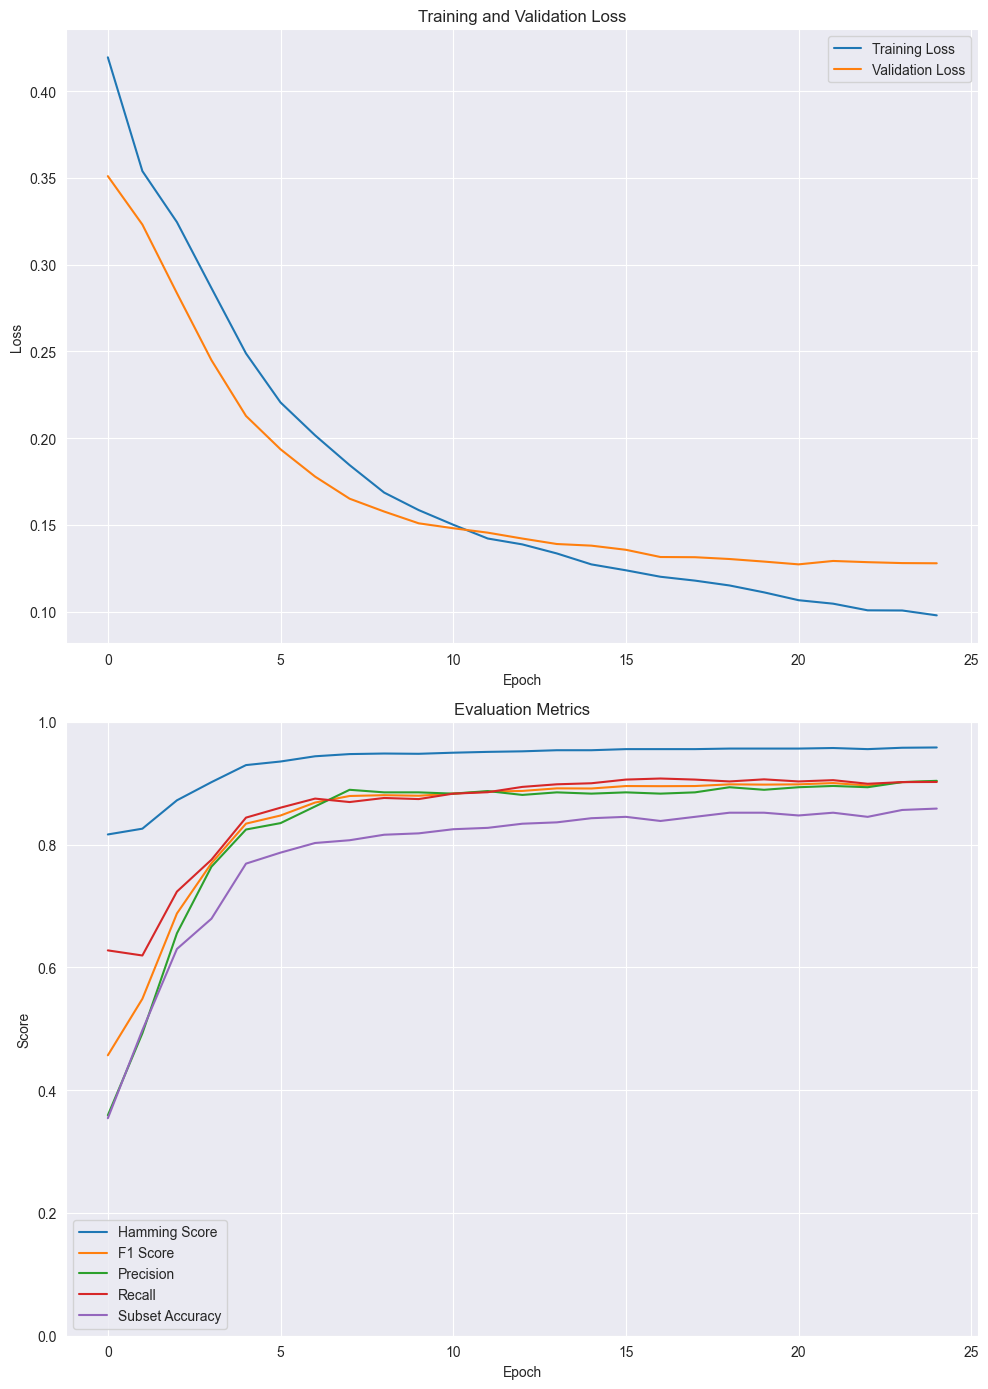

In [103]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(hamming_scores, label='Hamming Score')
ax2.plot(f1_scores, label='F1 Score')
ax2.plot(precision_scores, label='Precision')
ax2.plot(recall_scores, label='Recall')
ax2.plot(subset_accuracy_scores, label='Subset Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1]) 
ax2.set_ylabel('Score')
ax2.set_title('Evaluation Metrics')
ax2.legend()

plt.tight_layout()
plt.show()

The model achieves higher scores in metrics that are less sensitive to false negatives, such as Hamming Loss, compared to the F1, Precision and Recall, because the data is sparse, and it is more likely that the model will predict a label as negative, which may result in a higher number of false negatives. The prevalence of False Negatives is also observable on confusion matrices, especially if threshold is set to 0.5. Setting threshold value to 0.4 allows to increase the number of True Positives significantly, but also increases the number of False Positives slightly. Overall, decreasing threshold improved model performance. 

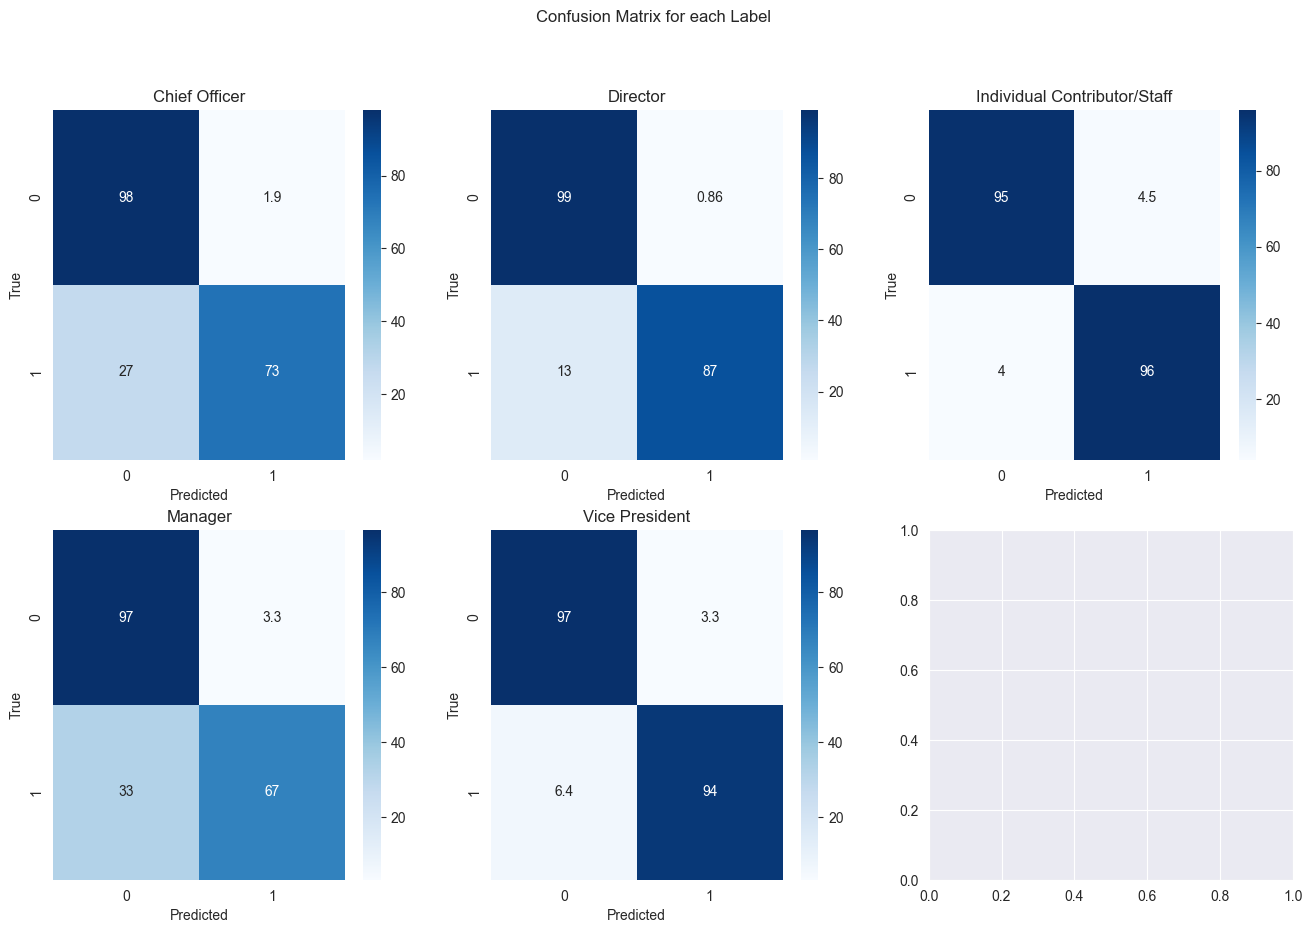

In [104]:
# TODO: https://ieeexplore.ieee.org/document/9711932 multi-label confusion matrix
cm = multilabel_confusion_matrix(best_targets.cpu().numpy(), best_predictions.cpu().numpy())

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])
""
plt.show()

In [105]:
report = classification_report(best_targets.cpu(), best_predictions.cpu(), target_names=classes_labels, zero_division=1)
print(report)

                              precision    recall  f1-score   support

               Chief Officer       0.73      0.73      0.73        30
                    Director       0.97      0.87      0.91        98
Individual Contributor/Staff       0.96      0.96      0.96       224
                     Manager       0.72      0.67      0.69        49
              Vice President       0.86      0.94      0.90        78

                   micro avg       0.90      0.89      0.90       479
                   macro avg       0.85      0.83      0.84       479
                weighted avg       0.90      0.89      0.90       479
                 samples avg       0.92      0.92      0.91       479



## Conclusion

The model performs well on the majority of labels; however, it encounters difficulties with the **"Manager"** and **"Chief Officer"** labels, which exhibit a high number of false negatives:
 - As observed from the EDA, the **"Manager"** label is often assigned to regular specialist titles, such as "Systems Engineer; Systems Architect," "Senior Security Architect / Information Security Officer," and so on. This titles do not explicitly indicate that the position should be labeled as a manager in any way, which limits the model's capacity to accurately capture the data. 
- Model may encounter difficulties in predicting **"Chief Officer"** labels due to the fact that in the dataset, titles often contain the words "Chief" or "Chief officer", but are not labelled as "Chief Officer".

Further exploration and improvements steps include:
- Stratifying the data during the train-test split to ensure a balanced distribution of labels in both sets.
- Baseline model implementation for comparison with more complex models. The baseline model could be a simple Logistic Regression classifier with TF-IDF vectorization.
- Trying a hybrid approach where BERT is used for generating embeddings that are then fed into a simpler classifier.